# How to Access the Hydrology Data Rods Time Series API

### Overview

This notebook describes accessing the [Hydrology Data Rods Time Series API](https://disc.gsfc.nasa.gov/information/tools?title=Hydrology%20Data%20Rods) using Python. It queries a grid over Brisbane, Australia, and queries 10 years of 3-hour GLDASv2.1 total precipitation rate data. Daily sums, means, and z-scores of this data are then calculated and plotted.

### Prerequisites

This notebook was written using Python 3.9, and requires these libraries and files:

- [requests](https://docs.python-requests.org/en/latest/) (version 2.22.0 or later)
- [Pandas](https://pandas.pydata.org/docs/index.html)
- [NumPy](https://numpy.org/doc/stable/index.html)
- [Matplotlib](https://matplotlib.org/)
- [Seaborn](https://seaborn.pydata.org/)


#### Import modules

In [1]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="darkgrid")
import urllib
import urllib.parse as urlp
import io
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

#### Define functions that call the data rods services, returns an ASCII, then converts the ASCII to a Pandas dataframe.


In [ ]:
def get_time_series(start_date,end_date,latitude,longitude,variable):
    """
    Calls the data rods service to get a time series
    """
    base_url = "https://hydro1.gesdisc.eosdis.nasa.gov/daac-bin/access/timeseries.cgi"
    query_parameters = {
        "variable": variable,
        "type": "asc2",
        "location": f"GEOM:POINT({longitude}, {latitude})",
        "startDate": start_date,
        "endDate": end_date,
    }
    full_url = base_url+"?"+ \
         "&".join(["{}={}".format(key,urlp.quote(query_parameters[key])) for key in query_parameters])
    print(full_url)
    iteration = 0
    done = False
    while not done and iteration < 5:
        r=requests.get(full_url)
        if r.status_code == 200:
            done = True
        else:
            iteration +=1
    
    if not done:
        raise Exception(f"Error code {r.status_code} from url {full_url} : {r.text}")
    
    return r.text

def parse_time_series(ts_str):
    """
    Parses the response from data rods.
    """
    lines = ts_str.split("\n")
    parameters = {}
    for line in lines[2:11]:
        key,value = line.split("=")
        parameters[key] = value
    
    
    df = pd.read_table(io.StringIO(ts_str),sep="\t",
                       names=["time","data"],
                       header=10,parse_dates=["time"])
    return parameters, df

#### Retrieve our precipitation data at the Brisbane grid

In [3]:

df_ts = parse_time_series(
        get_time_series(
            start_date="2012-06-01T00", 
            end_date="2022-05-31T23",
            latitude=-27.47,
            longitude=153.02,
            variable="GLDAS2:GLDAS_NOAH025_3H_v2.1:Rainf_f_tavg"
        )
    )

df_ts[1]

Confusing variable:  GLDAS2:GLDAS_NOAH025_3H_v2.1:Rainf_f_tavg
https://hydro1.gesdisc.eosdis.nasa.gov/daac-bin/access/timeseries.cgi?variable=GLDAS2%3AGLDAS_NOAH025_3H_v2.1%3ARainf_f_tavg&type=asc2&location=GEOM%3APOINT%28153.02%2C%20-27.47%29&startDate=2012-06-01T00&endDate=2022-05-31T23


,time,data
0,2012-06-01 00:00:00,0.000425
1,2012-06-01 03:00:00,0.000082
2,2012-06-01 06:00:00,0.000082
3,2012-06-01 09:00:00,0.000082
4,2012-06-01 12:00:00,0.000082
...,...,...
29211,2022-05-31 09:00:00,0.000062
29212,2022-05-31 12:00:00,0.000000
29213,2022-05-31 15:00:00,0.000000
29214,2022-05-31 18:00:00,0.000014


#### Plot using Matplotlib

''

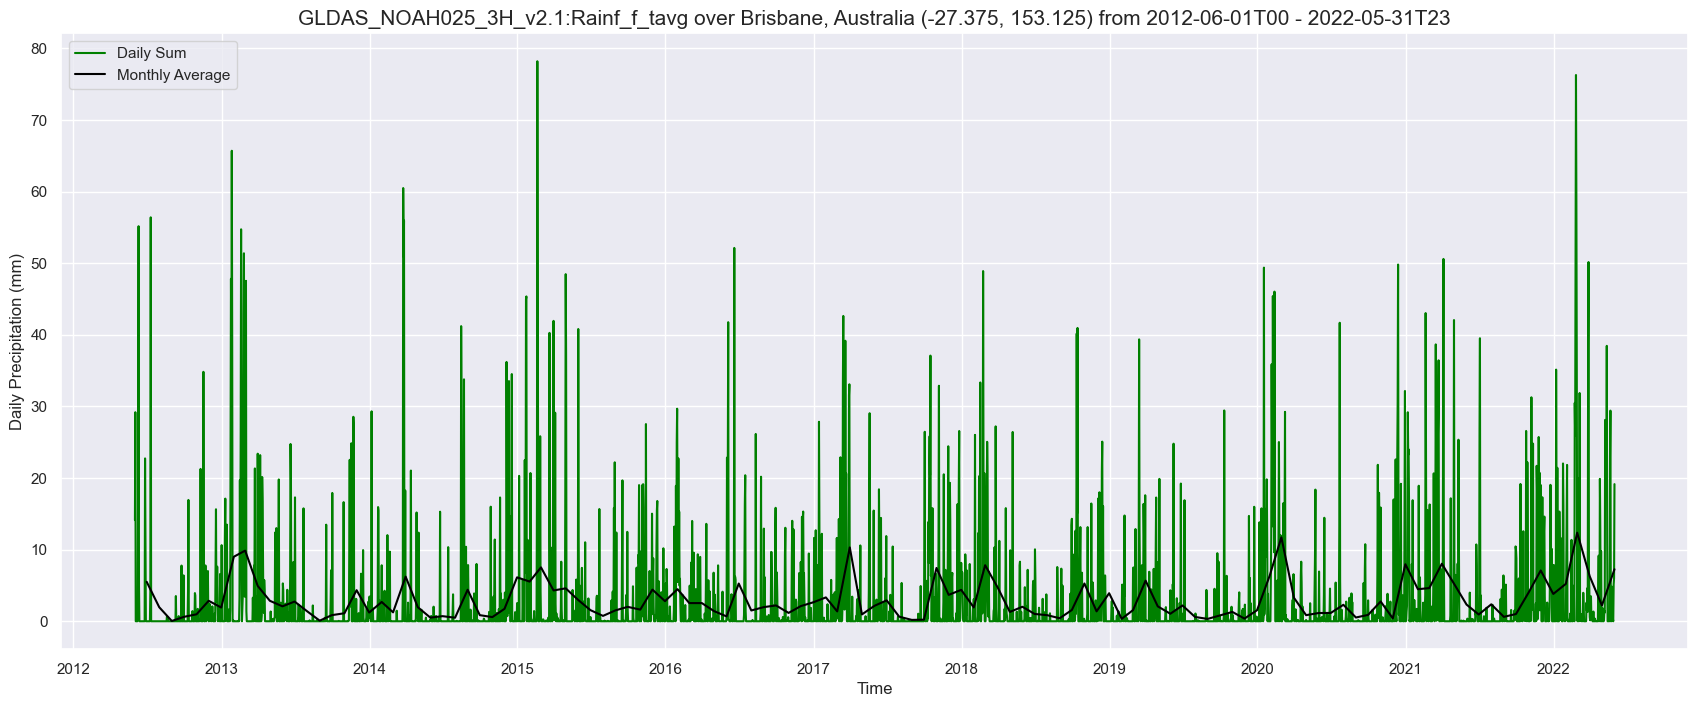

In [ ]:
plt.figure(figsize=(21, 8))

# Convert to mm, aggregate over days and months
daily_sum = df_ts[1].groupby(pd.Grouper(key='time', freq='1D')).sum()*3*3600
month_mean = (df_ts[1].groupby(pd.Grouper(key='time', freq='1D')).sum()*3*3600).resample("M").mean()

daily_sum = daily_sum.reset_index()
month_mean = month_mean.reset_index()

plt.plot(daily_sum["time"], daily_sum["data"], color="green")
plt.plot(month_mean["time"], month_mean["data"], color="black")

plt.title("GLDAS_NOAH025_3H_v2.1:Rainf_f_tavg over Brisbane, Australia (-27.375, 153.125) from 2012-06-01T00 - 2022-05-31T23", size=15)
plt.ylabel("Daily Precipitation (mm)")
plt.xlabel("Time")
plt.legend(["Daily Sum", "Monthly Average"])


#### Add year and month columns to our daily sums dataframe

In [5]:
daily_sum['year'] = ""
daily_sum['month'] = ""
daily_sum['year_ix'] = ""

for i in range(len(daily_sum)):
    daily_sum['year'].iloc[i] = daily_sum['time'].iloc[i].year
    daily_sum['month'].iloc[i] = daily_sum['time'].iloc[i].month

#### Create a Pandas pivot table, aggregate our daily sum values by month

In [6]:
months_pivot = daily_sum.pivot_table(index = "year", values="data", columns="month", aggfunc=np.sum)
months_pivot

month,1,2,3,4,5,6,7,8,9,10,11,12
year,,,,,,,,,,,,
2012,NaN,NaN,NaN,NaN,NaN,165.25188,60.63444,1.22472,18.42804,30.07908,85.69800,59.36976
2013,279.23184,276.12144,152.81784,85.69044,64.60452,82.47636,43.08336,2.55528,25.61112,34.60968,130.14648,37.68228
2014,83.48724,34.83432,193.16232,58.96692,15.66864,21.29868,15.35112,136.35000,25.52688,18.00792,52.09056,190.06920
2015,171.72540,210.62376,133.42752,137.87388,91.81944,46.60200,23.17248,47.31372,60.29748,50.40900,132.58296,86.94000
2016,138.84480,73.59228,78.56460,42.48180,20.96604,157.95864,46.63332,61.27812,66.19320,36.12816,63.32472,82.03464
2017,103.20156,38.55600,319.71240,28.60272,66.95352,87.56640,19.72188,5.85360,6.58800,230.65128,110.49912,135.85968
2018,59.69700,219.04884,146.15100,39.05712,62.84520,30.57372,26.35200,12.99888,47.19600,163.40400,41.56056,121.33476
2019,10.55160,43.61148,175.78404,62.38296,32.49504,66.11652,18.55764,10.15200,24.13800,40.40064,11.18124,47.79108
2020,196.36992,339.72372,101.75760,25.49448,35.64324,34.81380,71.27676,16.24428,26.55180,85.55760,12.14352,246.70332


#### Calculate 10-year z-scores of total monthly precipitation for our Brisbane grid

In [7]:
# Copy pivot table that will serve as our z-scores table
months_zscore = months_pivot.astype('float64')

for yr_ix in range(2012, 2023):
    for mo in range(1, 13):
        months_zscore[mo][yr_ix] = (months_pivot[mo][yr_ix] - months_pivot[mo].mean()) / months_pivot[mo].std()

#### Plot these results using a Seaborn "heatmap"

Text(0.5, 0.98, 'GLDAS Monthly Z-Scores of Total Precipitation in Brisbane, June-May 2012-2022')

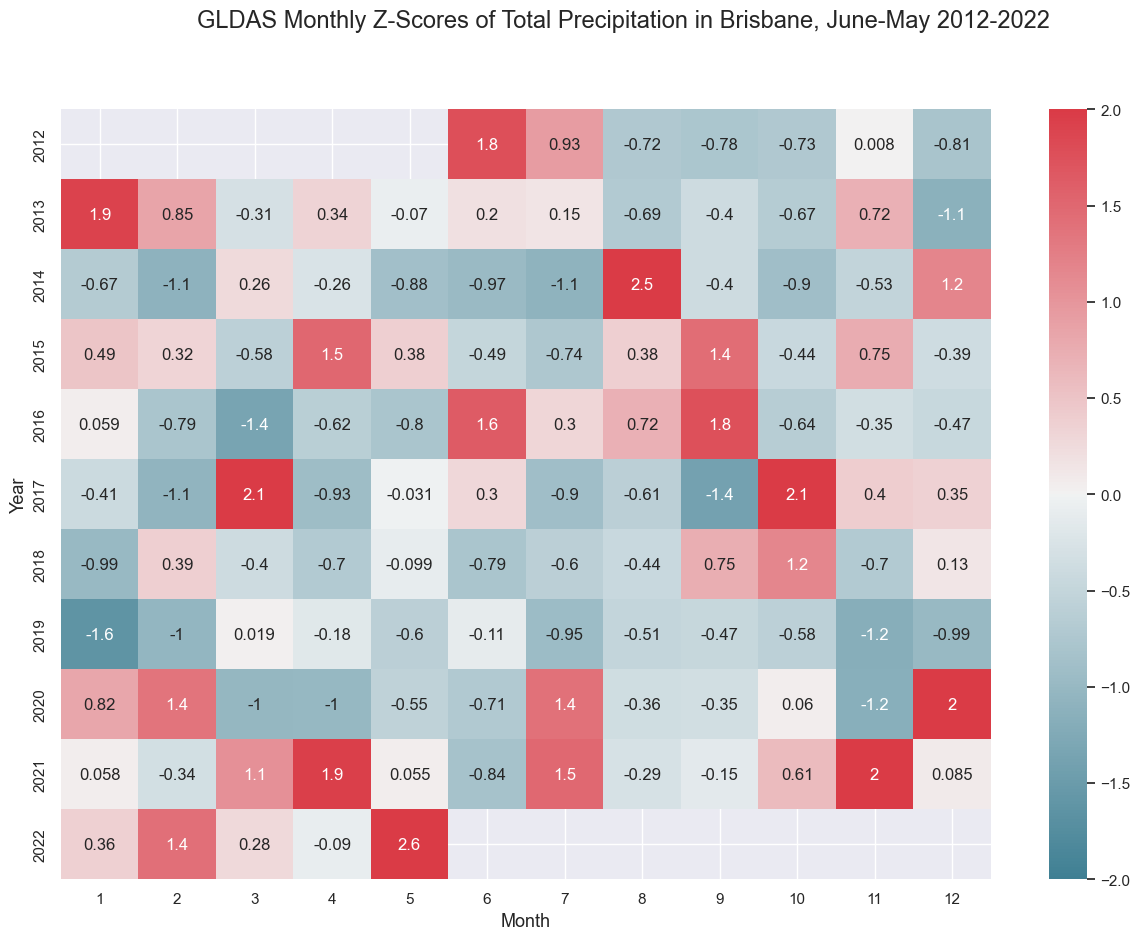

In [8]:
fig, ax = plt.subplots(figsize=(15, 10))
diverge = sns.diverging_palette(220, 10, as_cmap=True)

ax = sns.heatmap(months_zscore, cmap=diverge, center=0, vmin=-2, vmax=2, annot=True)
ax.set_xlabel("Month", fontsize=13)
ax.set_ylabel("Year", fontsize=13)

fig.suptitle("GLDAS Monthly Z-Scores of Total Precipitation in Brisbane, June-May 2012-2022", fontsize=17)